<a href="https://colab.research.google.com/github/raeubaen/ml/blob/master/nn/FFNN_shallow.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### FeedForward Shallow Neural Network Example with Keras/TF

A sequential model with 1 dense layer used to classify handwritten numbers (0 to 9) from the standard MINIST datatset  

In [0]:
#import models & layers from TF/keras
%tensorflow_version 2.x
import tensorflow as tf

gpu_name = tf.test.gpu_device_name()
if gpu_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(gpu_name))

from tensorflow import keras

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt

print(f"Tensorflow Version: {tf.__version__}")

Found GPU at: /device:GPU:0
Tensorflow Version: 2.2.0-rc2


In [0]:
#retrieve training data (MNIST dataset)
#60k images for training and 10k images for testing
mnist = keras.datasets.mnist

(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

#verify:
print ('images shape: ', train_images.shape)
print ('labels shape', train_labels.shape)

class_names = [
  'zero', 'uno', 'due', 'tre', 'quattro', 
  'cinque', 'sei', 'sette', 'otto', 'nove'
]

11493376/11490434 [==============================] - 0s 0us/step
images shape:  (60000, 28, 28)
labels shape (60000,)


NOTE: keras fornisce quattro arrays numpy:

* `train_images` e `train_labels`: training set e target (label) per il modello (vanno suddivisi in training e validation)
* `test_images` e `test_labels`: per il test delle prestazioni del modello (non devono mai essere usati per training o tuning degli iperparametri)

Le immagini sono array numpy formato $28\times28$ con pixel in scala di grigio con valori nel range $[0,256]$. <br>
Le label sono vettori di interi nel range $[0,...,9]$ che corrispondono al numero rappresentato in ogni immagine. 

Shape of train_images: (60000, 28, 28)
Number of train labels: 60000
Train labels: [5 0 4 ... 5 6 8]

Shape of test_images: (10000, 28, 28)
Number of test labels: 10000
test labels: [7 2 1 ... 4 5 6]


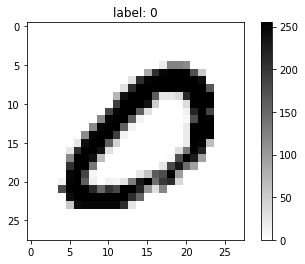

In [0]:
#Data exploration

print(f"Shape of train_images: {train_images.shape}")
print(f"Number of train labels: {len(train_labels)}")
print(f"Train labels: {train_labels}\n")
print(f"Shape of test_images: {test_images.shape}")
print(f"Number of test labels: {len(test_labels)}")
print(f"test labels: {test_labels}")

rnd = int(np.random.uniform()*len(train_labels))
plt.figure()
#plt.imshow(train_images[rnd])
plt.imshow(train_images[rnd], cmap=plt.cm.binary)
plt.title(f"label: {train_labels[rnd]}")
plt.colorbar()
plt.grid(False)
plt.show()

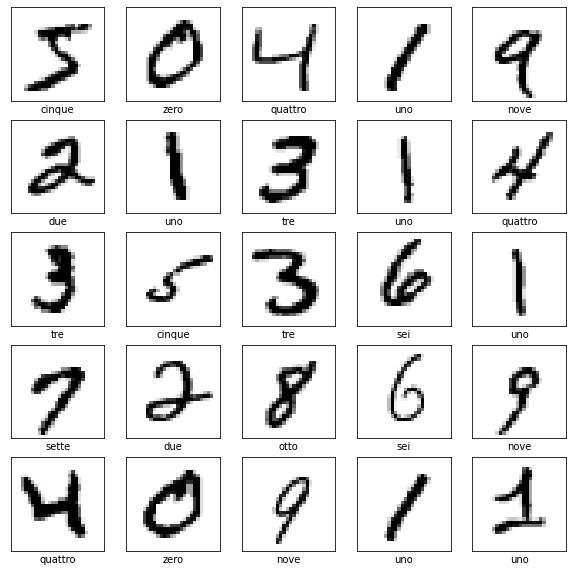

In [0]:
# plot 25 images to check everything is fine ...
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()

In [0]:
# encode the labels in category using one_hot encoding (builtin in keras)

train_labels_1h = keras.utils.to_categorical(train_labels)
test_labels_1h = keras.utils.to_categorical(test_labels)

print('label: ', train_labels_1h[rnd])

label:  [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [0]:
# convert images to flat vector of 28x28 pixels to be used in a dense layer 
# NOTE 
# you can do that here or (better approach)
# use a Flatten layer in the NN model as first layer
# in this example we use the Flatten layer ...

#train_images = train_images.reshape((60000, 28 * 28))
#test_images = test_images.reshape((10000, 28 * 28))

In [0]:
# Model definition (aka define the architecture of the network)

#sequential (aka Feed-Forward Neural Network)
model = keras.Sequential([
    
#first layer in this network, 
# tf.keras.layers.Flatten, transforms the format of the images from a 
#two-dimensional array (of 28 by 28 pixels) 
# to a one-dimensional array (of 28 * 28 = 784 pixels). 
#This prepare the flat input feature vector 
# containing al the pixels of each image for the NN
#This layer has no parameters to learn; it only reformats the data.
    
    keras.layers.Flatten(input_shape=(28, 28)),

#the network consists of a sequence of two tf.keras.layers.Dense layers. 
# These are densely connected, or fully connected, neural layers. 
# The first Dense layer has 256 nodes (or neurons) and activation function an 
#hyperbolic tangent, the second layer has 10 neurons with activation softmax: 
# means each one of the neurons output a probability [0,1] 
# with the constraint sum(outputs) = 1 (i.e. the output neurons add up to 1)
    
    keras.layers.Dense(256, activation='tanh'),
    keras.layers.Dense(10, activation='softmax')

])

In [0]:
# Model definition alternativa con il metodo funzionale ...
'''
inputs = keras.Input(shape=(28,28,))

x = keras.layers.Flatten()(inputs)
x = keras.layers.Dense(256, activation='tanh')(x)
outputs = keras.layers.Dense(10, activation='softmax')(x)

model = keras.Model(inputs=inputs, outputs=outputs, name='my_mnist_model')
'''

In [0]:
#Compile the model

# Training parameters: 
# we need to define: 
# * Loss function: this measures how accurate the model is during training
# * Optimizer: this is how the model is updated based on the data it sees
# * Metrics: used to monitor the training and testing steps

#sgd: stochastic gradient descent
#categorical_crossentropy: 
# loss that measure the the distance between two probability distributions  
# (the probability output and the true distribution of the labels)
model.compile(optimizer='sgd',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [0]:
#print summary of the model
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
flatten (Flatten)            (None, 784)               0         
_________________________________________________________________
dense (Dense)                (None, 256)               200960    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2570      
Total params: 203,530
Trainable params: 203,530
Non-trainable params: 0
_________________________________________________________________


In [0]:
# Train phase
# define batch_size for the stcastic gradient and number of epochs
# and the fraction of trainign events used for validation (validation_split)
with tf.device(gpu_name):
  history = model.fit(train_images/255, train_labels_1h, epochs=500, batch_size=128,
                      validation_split=0.2, shuffle=True, verbose=1)

In [0]:
#checks accuracy and loss on test sample

test_loss, test_acc = model.evaluate(test_images/255,  test_labels_1h, verbose=2)
print('\nTest accuracy:', test_acc)

313/313 - 1s - loss: 0.0683 - accuracy: 0.9787

Test accuracy: 0.9786999821662903


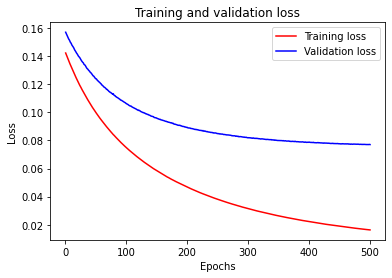

In [0]:
# plot traing and validation loss
import matplotlib.pyplot as plt

# retrieve the History produced by the fit: a dictionary containing data about 
# everything that happened during training

history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

#'r' = solid red line
#'b' = solid blue line
plt.plot(epochs, loss_values, 'r', label='Training loss')
plt.plot(epochs, val_loss_values, 'b', label='Validation loss')
plt.title('Training and validation loss')
#plt.axis([0,40,0.1,0.3])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

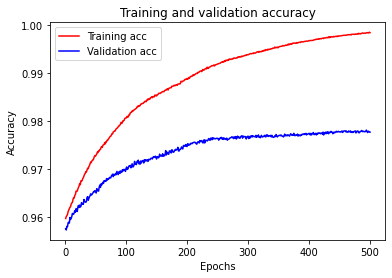

In [0]:
#plotting trainig and validation accuracy

acc_values = history_dict['accuracy'] 
val_acc_values = history_dict['val_accuracy']

plt.clf()
plt.plot(epochs, acc_values, 'r', label='Training acc')
plt.plot(epochs, val_acc_values, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
#plt.axis([0,11,0.9,1])
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

In [0]:
#use the trained newtrok for predictions on additional dataset

predictions = model.predict(test_images/255)

rnd = int(np.random.uniform()*len(test_labels_1h))

print(predictions[rnd])
print('Max probability for number:', np.argmax(predictions[rnd]))
print(test_labels[rnd])
print('True label is:', np.argmax(test_labels_1h[rnd]))

[4.7335877e-09 1.7070830e-05 9.9918073e-01 4.7832840e-05 1.2222966e-08
 2.1238600e-08 6.7919757e-07 7.5352733e-04 7.1398027e-08 5.6983655e-08]
Max probability for number: 2
2
True label is: 2


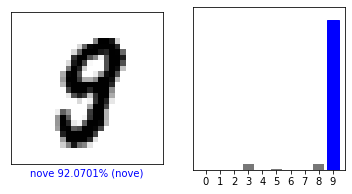

In [0]:
#Plot probabilities for the 10 classes
# Color correct predictions in blue and incorrect predictions in red.

def plot_image(i, predictions_array, true_label, img):
  predictions_array, true_label = predictions_array, np.argmax(true_label[i])
  img = img[i]
  plt.grid(False)
  plt.xticks([])
  plt.yticks([])

  plt.imshow(img, cmap=plt.cm.binary)

  predicted_label = np.argmax(predictions_array)
  if predicted_label == true_label:
    color = 'blue'
  else:
    color = 'red'

  plt.xlabel("{} {:2.4f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
  predictions_array, true_label = predictions_array, np.argmax(true_label[i])
  plt.grid(False)
  plt.xticks(range(10))
  plt.yticks([])
  thisplot = plt.bar(range(10), predictions_array, color="#777777")
  plt.ylim([0, 1])
  predicted_label = np.argmax(predictions_array)

  thisplot[predicted_label].set_color('red')
  thisplot[true_label].set_color('blue')


#example 0th-image
i = int(np.random.uniform()*len(test_images))
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels_1h, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels_1h)
plt.show()

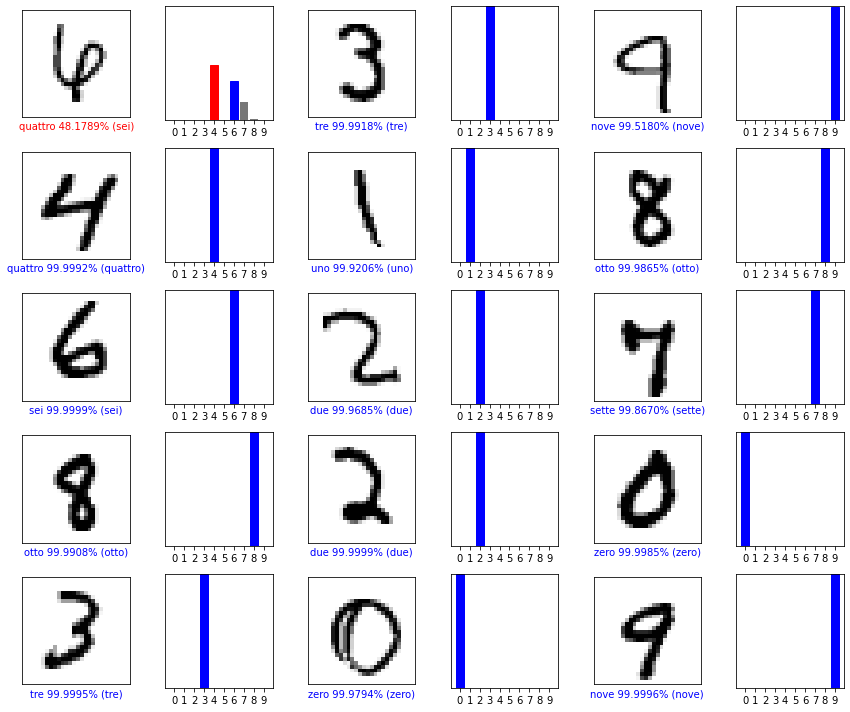

In [0]:
# Plot some test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
rnd_list = np.random.randint(0, len(test_images), size=num_rows*num_cols)
for i in range(num_rows*num_cols):
  rnd = rnd_list[i]
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(rnd, predictions[rnd], test_labels_1h, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(rnd, predictions[rnd], test_labels_1h)
plt.tight_layout()
plt.show()

Ho deciso di provare l'algoritmo con dei numeri scritti da me. <br>
Ho quindi scritto i numeri da 0 a 8 su un foglio con disegnata una griglia 3x3, ho posterizzato la foto e poi l'ho scalata a 84x84 (28x3=84).
Il risultato è buono, a parte che per il quattro, ma imputo tale comportamento ad un mio difetto di grafia.

In [0]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


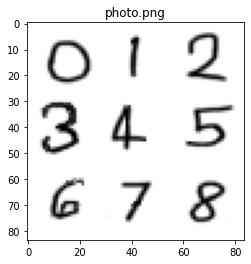

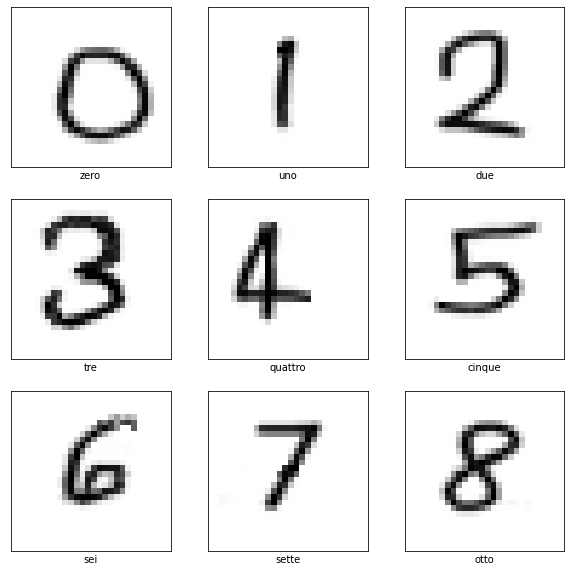

In [0]:
#test with photos of digits handwritten by me

from PIL import Image
file_name = "/content/drive/My Drive/Colab Notebooks/dataset/photo.png"
photo = (256 - np.asarray(Image.open(file_name).convert("L")))
plt.imshow(photo, cmap=plt.cm.binary)
plt.title("photo.png")
plt.show()
plt.close()

X, Y = np.asarray(photo.shape)//3

_images = []
for i in range(3):
    for j in range(3):
        image = photo[X*i : X*(i+1), Y*j : Y*(j+1)]
        _images.append(image)
        
images = np.asarray(_images)

plt.figure(figsize=(10,10)) 
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[i])
plt.show()

In [0]:
pred = model.predict(images/255)
labels = keras.utils.to_categorical(range(9))

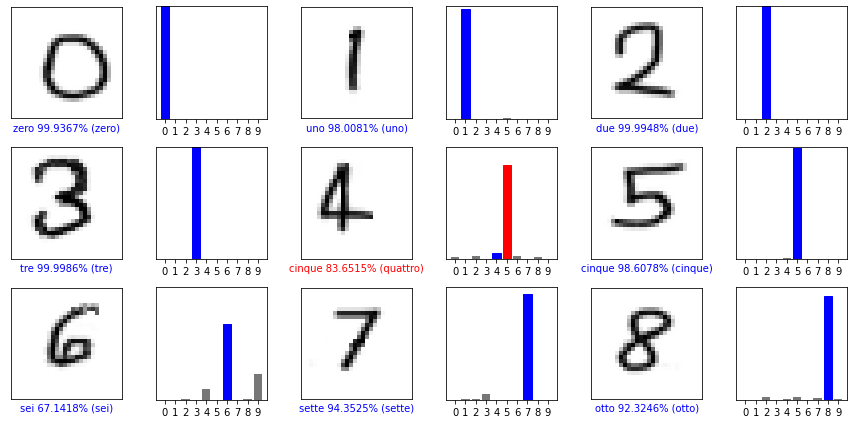

In [0]:
num_rows = 3
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, pred[i], labels, images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, pred[i], labels)
plt.tight_layout()
plt.show()

Plotto 100 quattro presenti nel dataset, il che mostra che sono quasi tutti tristemente diversi dal mio.

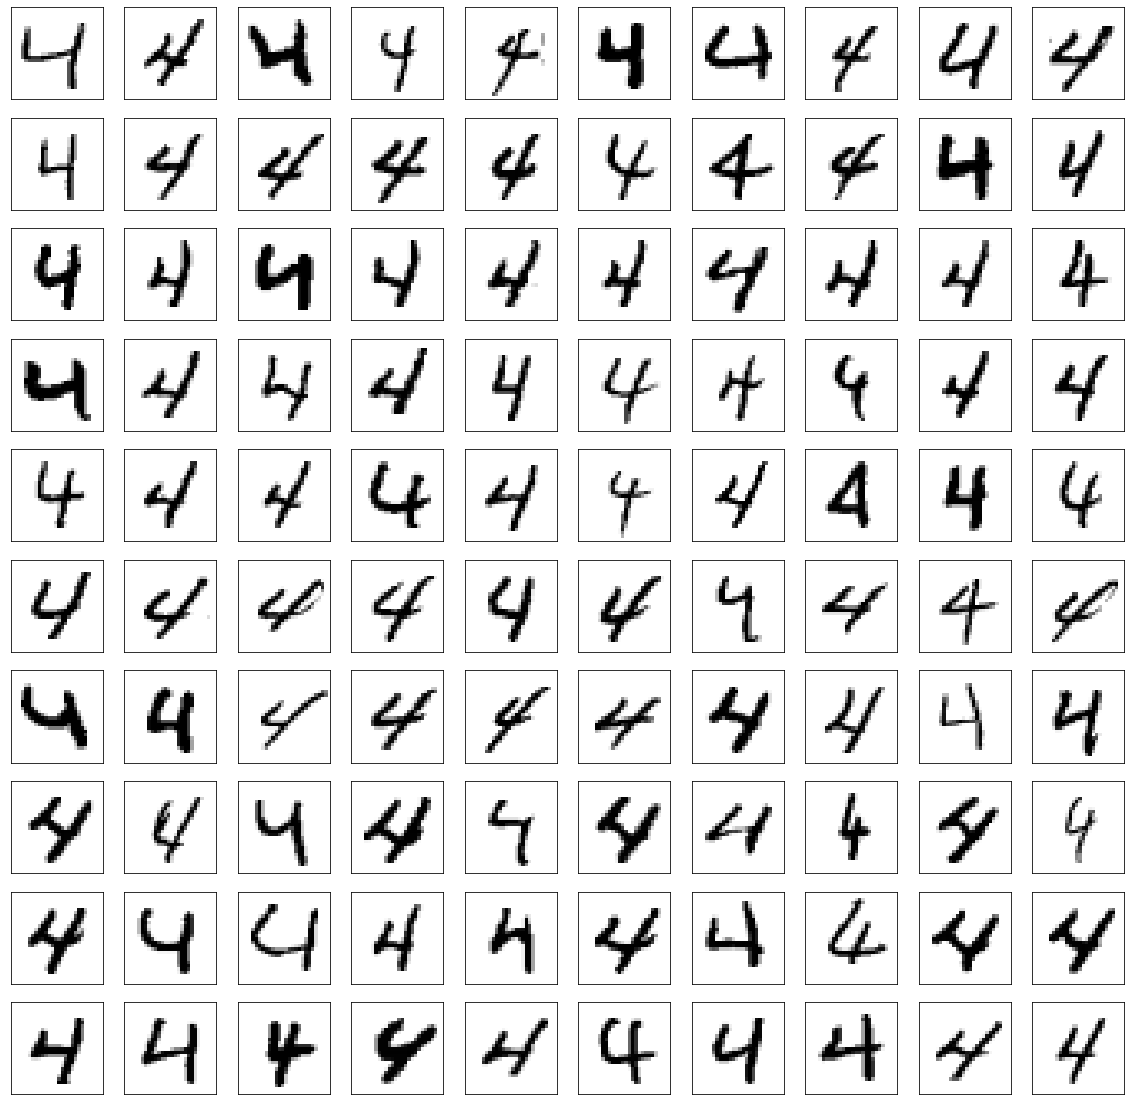

In [0]:
fours = train_images[train_labels==4][: 100]
plt.close()
plt.figure(figsize=(20,20))
for i in range(100):
    plt.subplot(10,10,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(fours[i], cmap=plt.cm.binary)
plt.show()